<a href="https://colab.research.google.com/github/dafisilva/CTM_internship/blob/main/CTM_SUMMER_MAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **PRE - PROCESSING**

In [ ]:
import os 
import numpy as np
from sklearn.model_selection import StratifiedKFold
import pickle
from PIL import Image

num_classes=4;
divs=5;

PATH=r'/content/drive/MyDrive/CTM_Dataset/Dataset'
classes=['Negative for Intraepithelial malignancy','Low squamous intra-epithelial lesion', 'High squamous intra-epithelial lesion',  'Squamous cell carcinoma']
directories=os.listdir(PATH)
X=[]
Y=[]

for folder in directories:
  
  sub_path=os.path.join(PATH,folder)
  imgs_name=[x for x in os.listdir(sub_path) if x.endswith('.jpg')]
  imgs=[os.path.join(sub_path,x) for x in imgs_name]
  labels=[classes.index(folder)for i in range(len(imgs_name))]
  X+=imgs;
  Y+=labels;

X,Y=np.array(X),np.array(Y)

#without test set:
skf=StratifiedKFold(n_splits=divs,shuffle=True,random_state=1234)
data_dict=[{'train':(X[tr],Y[tr]),'test':(X[ts],Y[ts])} for tr,ts in skf.split(X,Y)]

#with test set:
skf2=StratifiedKFold(n_splits=2,shuffle=True,random_state=1234)
new_data_dict=[]
for x in data_dict:
  tr,tv = skf2.split(x['train'][0],x['train'][1])
  new_data_dict.append({'train':(x['train'][0][tr[0]],x['train'][1][tr[0]]),'val':(x['train'][0][tv[0]],x['train'][1][tv[0]]),'test':x['test']})


    

pickle.dump(new_data_dict,open(r'/content/drive/MyDrive/CTM_Dataset/Pickle/data.p','wb'))

In [ ]:
len(new_data_dict[0]['test'][0])


193

# **CUSTOM DATASET**

In [1]:
%%writefile customdataset.py
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import pickle


class CustomDataset(Dataset):
    def __init__(self,pickle_root,fold,stage,transform):
        
        self.transform=transform;
        self.X,self.Y=pickle.load(open(pickle_root,"rb"))[fold][stage]
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        
        image=Image.open(self.X[idx])
        label=self.Y[idx]
        
        if self.transform:
            image=self.transform(image);
        return image,label
    
      
transform={'train':transforms.Compose(
    [
     
     transforms.Resize((224,224)),
     transforms.RandomAffine(180, (0, 0.1), (0.9, 1.1)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.ColorJitter(saturation=(0.5, 2.0)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
     ]),
    'test':transforms.Compose(
    [
     
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
     ])}

Writing customdataset.py


# **NETWORK**

In [3]:
%%writefile neural_net.py
import torch
from torch import nn
from torchvision import models

cross=nn.BCEWithLogitsLoss()

class Network(nn.Module):
    def __init__(self,pt_model,K):
        super().__init__()           #usar os métodos da nn.Module
        model_ft=models.resnet18(pretrained=True)  #abrir o modelo pré-treinado
        layers_list=list(model_ft.children())[:-1] # obter uma list com todas as layers do modelo pré-treinado, exceto a última.
        model_ft=nn.Sequential(*layers_list)   # novo modelo atualizado sem a última layer
        last_dim=torch.flatten(model_ft(torch.randn(1,3,224,224))).shape[0] # obter a dimensão da ultima layer, de forma a sabermos que valor usar para a linearização
        print(last_dim)
        self.model=nn.Sequential(
            model_ft,
            nn.Flatten(),                    #reshape input para tensor 1-D
            nn.Dropout(0.2),                 #"zerar" de forma aleatória alguns elementos do tensor, com probabilidade ainda por ser definida (testar)
            nn.Linear(last_dim,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,4)
            )
    def forward(self,x):
        return self.model(x)
    
    def loss(self,pred,gtruth):
        
        return cross(pred,gtruth)

    def soft(self,out):
        return nn.functional.softmax(out,dim=1)
    def pred(self,pred):
        return torch.max(pred,1)
        
class Ordinal_Encoder(Network):
  def __init__(self, pretrained_model, K):
        super().__init__(pretrained_model, K-1)
        self.K = K
  def loss_ord(self, Yhat, Y):
        KK = torch.arange(4, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')).expand(Y.shape[0], -1)
        YY = (Y[:, None] > KK).float()
        return cross(Yhat, YY)
  def to_proba(self, Yhat):
        Phat = torch.sigmoid(Yhat)
        Phat = torch.cat((1-Phat[:, :1], Phat[:, :-1] - Phat[:, 1:], Phat[:, -1:]), 1)
        return torch.clamp(Phat, 0, 1)


Writing neural_net.py


# **MODEL TRAINING**

In [1]:
%%writefile train.py
import argparse
from customdataset import CustomDataset,transform
from neural_net import Network,Ordinal_Encoder
from sklearn import metrics
from torch.utils.data import DataLoader
import torch
import os 
import numpy as np 
import copy
from tqdm import tqdm

parser=argparse.ArgumentParser()

parser.add_argument('model',choices=['mobilenet_v3_large','vgg16','resnext50_32x4d','resnet18'],default='resnet18')
parser.add_argument('fold',default=3)
parser.add_argument('epochs',type=int,default=100)
parser.add_argument('batchsize',type=int,default=32)
parser.add_argument('lr',type=float,default=1e-4)
parser.add_argument('path',default=None)
args=parser.parse_args()

root=r'/content/drive/MyDrive/CTM_Dataset/Pickle/data.p'

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trainset=CustomDataset(root,int(args.fold),'train',transform['train'])
validset=CustomDataset(root,int(args.fold),'val',transform['test'])
testset=CustomDataset(root,int(args.fold),'test',transform['test'])


def train(trainloader,path,validloader=None,epochs=10):
    tr_acc=[]
    #tr_bal_acc=[]
    #tr_f1=[]
    tr_loss=[]
    tr_mae=[]
    tr_recall=[];
    tr_precision=[];
    
    tval_acc=[]
    #tval_bal_acc=[]
    #tval_f1=[]
    tval_loss=[]
    val_mae=[]
    val_recall=[]
    val_precision=[]
    
    best_acc=0
    
    for epoch in range(epochs):
        
        print('EPOCH NUMBER %d OF %d'%(epoch,epochs))
        #bal_acc=0;
        avg_acc=0;
        avg_loss=0;
        #f1_score=0;
        mae=0;
        recall=0;
        precision=0;
        model.train()
        for inputs,labels in tqdm(trainloader):
            
            
            inputs,labels=inputs.to(device),labels.to(device,torch.int64)   
            optim.zero_grad()
            outputs=model(inputs)
            print(outputs)
            loss=model.loss_ord(outputs,labels)
            #outputs=model.soft(outputs)
            loss.backward()
            optim.step()
            c_pred=model.pred(outputs)[1]
            avg_acc+=(labels.cpu()==c_pred.cpu()).float().mean()/len(trainloader)
            avg_loss+=loss.cpu()/len(trainloader)
            #bal_acc+=metrics.balanced_accuracy_score(labels.cpu(),c_pred.cpu())/len(trainloader)
            mae+=metrics.mean_absolute_error(labels.cpu(), c_pred.cpu())/len(trainloader)
            recall+=metrics.recall_score(labels.cpu(), c_pred.cpu(),average='weighted',zero_division=1)/len(trainloader)
            precision+=metrics.precision_score(labels.cpu(), c_pred.cpu(),average='weighted',zero_division=1)/len(trainloader)
            #f1_score+=metrics.f1_score(labels.cpu(),c_pred.cpu(),average=None)/len(trainloader)
        
        
        print('TRAINING RESULTS:\nACCURACY: %.2f LOSS: %.3f MAE: %.2f RECALL: %.2f PRECISION: %.2f'%(avg_acc,avg_loss,mae,recall,precision))
        
        tr_acc+=[avg_acc]
        #tr_bal_acc+=[bal_acc]
        #tr_f1+=[f1_score]
        tr_loss+=[avg_loss.detach().numpy()]
        tr_mae+=[mae]
        tr_recall+=[recall]
        tr_precision+=[precision]
        
        
        
        
        if validloader is not None:
            
            
            val_acc,val_loss,mae,recall,precision=test(validloader,True)
            tval_acc+=[val_acc]
            #tval_bal_acc+=[val_bal_acc]
            val_mae+=[mae]
            #tval_f1+=[val_f1]
            tval_loss+=[val_loss]
            val_recall+=[recall]
            val_precision+=[precision]
            if val_acc>best_acc:
                best_acc=val_acc;
                best_model=copy.deepcopy(model.state_dict())
    np.savez(os.path.join(path,'training.npz'),tr_acc=tr_acc,tr_loss=tr_loss,mae=mae,recall=recall,precision=precision)
    if validloader is not None:       
        np.savez(os.path.join(path,'validation.npz'),tval_acc=tval_acc,tval_loss=tval_loss,mae=mae,recall=recall,precision=precision)
    model.load_state_dict(best_model)
    torch.save(model.state_dict(),os.path.join(path,'model.pth'))

def test(testloader,val=False):
   with torch.no_grad():
       model.eval()
       app_label=[]
       app_pred=[]
       avg_acc=0;
       avg_loss=0;
       #bal_acc=0
       mae=0
       recall=0
       precision=0
       #f1_score=0;
       for inputs,labels in tqdm(testloader):
           inputs,labels=inputs.to(device),labels.to(device,torch.int64)
           outputs=model(inputs)
           
           #outputs=model.soft(outputs)
           loss=model.loss_ord(outputs,labels)       
           c_pred=model.pred(outputs)[1]
           avg_acc+=(labels.cpu()==c_pred.cpu()).float().mean()/len(testloader)
           avg_loss+=loss.cpu()/len(testloader)
           app_label+=labels.cpu()
           app_pred+=c_pred.cpu()
           
           #bal_acc+=metrics.balanced_accuracy_score(labels.cpu(),c_pred.cpu())/len(testloader)
           mae+=metrics.mean_absolute_error(labels.cpu(), c_pred.cpu())/len(testloader)
           recall+=metrics.recall_score(labels.cpu(), c_pred.cpu(),average='weighted',zero_division=1)/len(testloader)
           precision+=metrics.precision_score(labels.cpu(), c_pred.cpu(),average='weighted',zero_division=1)/len(testloader)
           #f1_score+=metrics.f1_score(labels.cpu(),c_pred.cpu())/len(testloader)
       
       print('TESTING RESULTS:\nACCURACY: %.2f  LOSS: %.3f MAE: %.2f RECALL: %.2f PRECISION: %.2f'%(avg_acc,avg_loss,mae,recall,precision))           
       print('\nCONFUSION MATRIX:')
       print(metrics.confusion_matrix(app_label,app_pred))
       if val:
           return avg_acc,avg_loss,mae,recall,precision 
             
if __name__=='__main__':

    trainloader,validloader=DataLoader(trainset,args.batchsize,shuffle=True,num_workers=2),DataLoader(validset,args.batchsize,shuffle=False,num_workers=2)   
    #model=Network(args.model)
    model=Ordinal_Encoder(args.model,4)
    model=model.to(device)  
    optim=torch.optim.Adam(model.parameters(),args.lr)
    path=os.path.join(r'/content/drive/MyDrive/CTM_Dataset/Results',args.path)
    os.mkdir(path)
    train(trainloader,path,validloader,args.epochs)


    #testloader=DataLoader(testset,args.batchsize,shuffle=False,num_workers=2) 
    #model=Network(args.model)
    #ordinal_enc=Ordinal_Encoder(model,4)
    #path='/content/drive/MyDrive/CTM_Dataset/Results/resnet18_100e_64b_lr4_no_aug_f'
    #for i in range(5):
    #  new_path=path+str(i)
    #  model.load_state_dict(torch.load(os.path.join(new_path,'model.pth')))
    #  model=model.to(device)
    #  model.eval()
    #  print(model.parameters())
    #  avg_acc,avg_loss,mae,recall,precision=test(testloader,True)
    #  np.savez(os.path.join(new_path,'testing.npz'),avg_acc=avg_acc,avg_loss=avg_loss,mae=mae,recall=recall,precision=precision)

Writing train.py


# **POWERSHELL SIMULATOR**

In [ ]:
!python train.py resnet18 0 100 64 1e-4 'resnet18_100e_64b_lr4_ord_enc_f0'
#!python train.py resnet18 1 100 64 1e-4 'resnet18_100e_64b_lr4_ord_enc_f1'
#!python train.py resnet18 2 100 64 1e-4 'resnet18_100e_64b_lr4_ord_enc_f2'
#!python train.py resnet18 3 100 64 1e-4 'resnet18_100e_64b_lr4_ord_enc_f3'
#!python train.py resnet18 4 100 64 1e-4 'resnet18_100e_64b_lr4_ord_enc_f4'

# **GRAPHS**

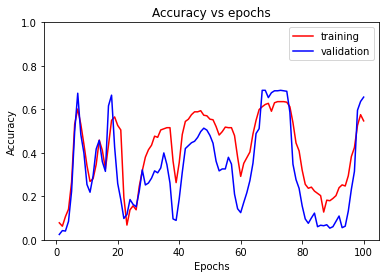

<Figure size 432x288 with 0 Axes>

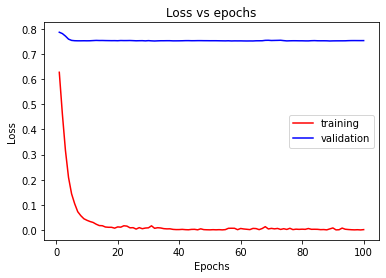

In [46]:
import numpy as np
import matplotlib.pyplot as plt

training=np.load(r'/content/drive/MyDrive/CTM_Dataset/Results/resnet18_100e_64b_lr4__f0/training.npz')
validation=np.load(r'/content/drive/MyDrive/CTM_Dataset/Results/resnet18_100e_64b_lr4_ord_enc_f0/validation.npz')

tr_acc=training['tr_acc']
mae=training['mae']
tr_loss=training['tr_loss']

val_acc=validation['tval_acc']
val_mae=validation['mae']
val_loss=validation['tval_loss']

epochs=[i+1 for i in range(100)]

plt.figure()


plt.plot(epochs,tr_acc,'r',label='training')
plt.plot(epochs,val_acc,'b',label='validation')
plt.title('Accuracy vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0,1)
plt.figure()

#plt.plot(epochs,mae,'r',label='training')
#plt.plot(epochs,val_mae,'b',label='validation')
#plt.title('Mean Average Error vs epochs')
#plt.xlabel('Epochs')
#plt.ylabel('MAE')
#plt.legend()
#plt.ylim(0,1)

plt.figure()
plt.plot(epochs,tr_loss,'r',label='training')
plt.plot(epochs,val_loss,'b',label='validation')
plt.title('Loss vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os 
path='/content/drive/MyDrive/CTM_Dataset/Results/resnet18_100e_64b_lr4_no_aug_f'
acc=[]
mae=[]
loss=[]
recall=[]
precision=[]
for i in range(5):
  new_path=path+str(i)
  test=np.load(os.path.join(new_path,'testing.npz'))


  acc+=[test['avg_acc']]
  mae+=[test['mae']]
  loss+=[test['avg_loss']]
  recall+=[test['recall']]
  precision+=[test['precision']]



print(acc)
print(mae)
print(loss)
print(recall)
print(precision)

[array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(0.97916675, dtype=float32)]
[array(0.), array(0.), array(0.), array(0.), array(0.02083333)]
[array(0.7459378, dtype=float32), array(0.7495118, dtype=float32), array(0.745107, dtype=float32), array(0.75130373, dtype=float32), array(0.76630396, dtype=float32)]
[array(1.), array(1.), array(1.), array(1.), array(0.97916667)]
[array(1.), array(1.), array(1.), array(1.), array(0.98185484)]


In [11]:
acc

[array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(0.97916675, dtype=float32)]

# **CAPTUM**

In [ ]:
!pip install captum
from captum.attr import IntegratedGradients
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
import argparse
from customdataset import CustomDataset,transform
from neural_net import Network
from sklearn import metrics
from torch.utils.data import DataLoader
import torch
import os 
import numpy as np 
import copy


testloader=DataLoader(testset,args.batchsize,shuffle=False,num_workers=2) 
model=Network('resnet18')
path='/content/drive/MyDrive/CTM_Dataset/Results/resnet18_100e_64b_lr4_new_Data_f0'
   
model.load_state_dict(torch.load(os.path.join(new_path,'model.pth')))
model=model.to(device)
model.eval()
print(model.parameters())
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions    
for images,labels in (testloader):
  
  images, labels = images.to(device),labels.to(device)
  outputs = model(images)
  outputs=model.soft(outputs)
  loss=model.loss(outputs,labels)       
  c_pred=model.pred(outputs)[1]
  for ind in range(64):
      input=images[ind].unsqueeze(0)
      input.requires_grad=True
      saliency = Saliency(model)
      grads = saliency.attribute(input, target=labels[ind].item(),abs=False)
      grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))
      original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
      fig = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="all",
                            show_colorbar=True, title="Overlayed Gradient Magnitudes");